## BREAST CANCER DETECTION
Ahmet Deniz Güner 21627279

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext
import seaborn as sns; sns.set()
from pyspark.sql.functions import col, when 
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler

%matplotlib inline
pd.options.display.max_columns = None

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from pyspark.sql import SQLContext
sc =SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

### Load the data

In [0]:
df = sqlContext.read.csv('data.csv', header=True)

### Understanding Data
View general statistical information of data for deceding the process in data preperation part.

In [7]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- diagnosis: string (nullable = true)
 |-- radius_mean: string (nullable = true)
 |-- texture_mean: string (nullable = true)
 |-- perimeter_mean: string (nullable = true)
 |-- area_mean: string (nullable = true)
 |-- smoothness_mean: string (nullable = true)
 |-- compactness_mean: string (nullable = true)
 |-- concavity_mean: string (nullable = true)
 |-- concave points_mean: string (nullable = true)
 |-- symmetry_mean: string (nullable = true)
 |-- fractal_dimension_mean: string (nullable = true)
 |-- radius_se: string (nullable = true)
 |-- texture_se: string (nullable = true)
 |-- perimeter_se: string (nullable = true)
 |-- area_se: string (nullable = true)
 |-- smoothness_se: string (nullable = true)
 |-- compactness_se: string (nullable = true)
 |-- concavity_se: string (nullable = true)
 |-- concave points_se: string (nullable = true)
 |-- symmetry_se: string (nullable = true)
 |-- fractal_dimension_se: string (nullable = true)
 |-- radiu

In [8]:
df.describe().show()

+-------+--------------------+---------+------------------+-----------------+-----------------+-----------------+--------------------+-------------------+-------------------+--------------------+--------------------+----------------------+------------------+------------------+------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+-----------------+--------------------+-------------------+-------------------+--------------------+-------------------+-----------------------+----+
|summary|                  id|diagnosis|       radius_mean|     texture_mean|   perimeter_mean|        area_mean|     smoothness_mean|   compactness_mean|     concavity_mean| concave points_mean|       symmetry_mean|fractal_dimension_mean|         radius_se|        texture_se|      perimeter_se|          area_se|       smoothness_se|      compactness_

### Data Preperation
Firstly I convert the columns to float (excpect id, _c32 and diagnosis column) because they are string after that I dropped empty column _c32.

In [9]:
FEATURES_COL = ['id','_c32|','diagnosis']
for col in df.columns:
    if col  not in FEATURES_COL:
        df = df.withColumn(col,df[col].cast('float'))
df = df.drop("_c32")
df.show()

+--------+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|      id|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|
+--------+---------+-----------+------------+---

I define Shape function for acssesin size of dataframe easily.  

In [10]:
def shape(dataframe):
    row_number = dataframe.count()
    column_number = len(dataframe.dtypes)
    print("Shape: " + str(row_number)+" , " + str(column_number))
shape(df)

Shape: 569 , 32


I dropped empty rows and I checked is there any dropped rows but there is not empty rows.

In [11]:
df = df.na.drop()
shape(df)

Shape: 569 , 32


I examined the Malihnent and Bening numbers and visualized them with a pie chart.

In [12]:
count = df.groupBy('diagnosis').count()
counts = count.toPandas()
print(counts)

  diagnosis  count
0         B    357
1         M    212


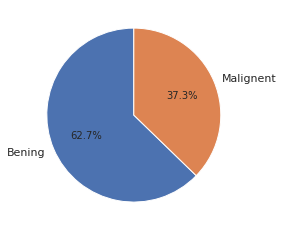

In [13]:
labels = 'Bening', 'Malignent'
sizes = [counts["count"][0],counts["count"][1]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.show()

I converted the diagnosis column to numercial value for using by modelling after that I checked the data frame.

In [0]:
from pyspark.sql.functions import col, trim, lower
df = df.withColumn("diagnosis",when(col("diagnosis") == "M", 0).when(col("diagnosis") == "B", 1).otherwise(2))

In [15]:
df.show()

+--------+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|      id|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|
+--------+---------+-----------+------------+---

I scaled data with using min-max scaling.

In [16]:
df2 = df.drop("id")
columns_to_scale = df2.columns
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_scale]
scalers = [MinMaxScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in columns_to_scale]
pipeline = Pipeline(stages=assemblers + scalers)
scalerModel = pipeline.fit(df2)
scaledData = scalerModel.transform(df2)

vectoredData = scaledData;
for col in df2.columns:
    vectoredData = vectoredData.drop(col)
    vectoredData = vectoredData.drop(col + "_scaled" )
shape(vectoredData)
vectoredData.show() 

for col in df2.columns:
    scaledData = scaledData.drop(col)
    scaledData = scaledData.drop(col + "_vec" )
shape(scaledData)
scaledData.show()  

normalized_df=(df2.toPandas()-df2.toPandas().min())/(df2.toPandas().max()-df2.toPandas().min())
data = sqlContext.createDataFrame(normalized_df)

Shape: 569 , 31
+-------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+-----------------------+--------------------+--------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------------+--------------------+------------------------+--------------------+--------------------+--------------------+-------------------+--------------------+---------------------+--------------------+------------------------+--------------------+---------------------------+
|diagnosis_vec|     radius_mean_vec|    texture_mean_vec|  perimeter_mean_vec|      area_mean_vec| smoothness_mean_vec|compactness_mean_vec|  concavity_mean_vec|concave points_mean_vec|   symmetry_mean_vec|fractal_dimension_mean_vec|       radius_se_vec|      texture_se_vec|    perimeter_se_vec|         area_se_v

### Clustering Model and Evaluation
I tried clustering first vectored and scaled data.Firstly I find the optimal cluster number with using by elbow method that 2.

Text(0, 0.5, 'cost')

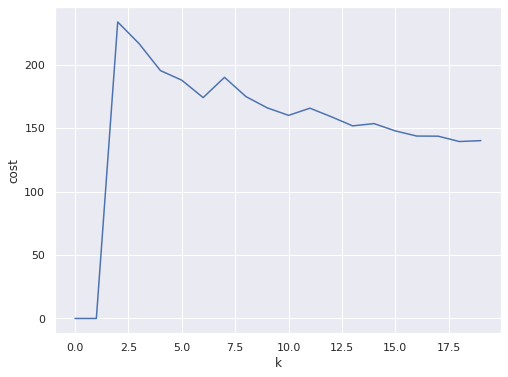

In [17]:
vecAssembler = VectorAssembler(inputCols=scaledData.drop("diagnosis").columns, outputCol="features")
df_kmeans_scaled = vecAssembler.transform(scaledData.drop("diagnosis")).select("features" )

cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans_scaled.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(df_kmeans_scaled) # requires Spark 2.0 or later
    
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(0,20),cost[0:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

I applyied clusterin with k=2 and I calculated accurcy of clustering with scaled data and I get the %99 result.

In [18]:
k = 2
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans_scaled)
centers = model.clusterCenters()

transformed = model.transform(df_kmeans_scaled).select('prediction')
rows = transformed.collect()
df_pred = sqlContext.createDataFrame(rows)

prediction = df_pred.toPandas()
prediction = prediction.rename(columns={"prediction": "diagnosis",})

acctual = df2.select('diagnosis').toPandas()

accurcy_Normalized = prediction == acctual
countNor = 0
for item in accurcy_Normalized.diagnosis:
    if item == False:
        countNor = countNor + 1
print("Accurucy of clustering of  scaled data % " + str(100*countNor/569))

Accurucy of clustering of  scaled data % 99.82425307557118


I tried clustering  vectored but not scaled data.Firstly I find the optimal cluster number with using by elbow method that 2.

Text(0, 0.5, 'cost')

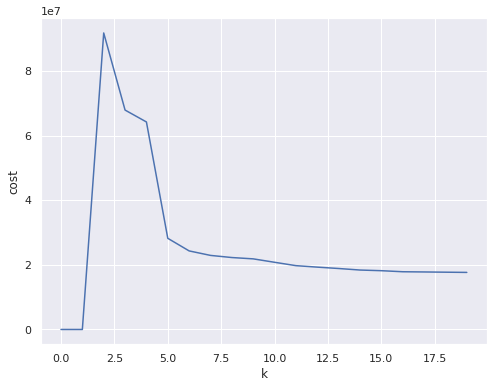

In [19]:
vecAssembler = VectorAssembler(inputCols=vectoredData.drop("diagnosis").columns, outputCol="features")
df_kmeans = vecAssembler.transform(vectoredData.drop("diagnosis")).select("features" )

cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(df_kmeans) # requires Spark 2.0 or later
    
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(0,20),cost[0:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

I applyied clusterin with k=2 and I calculated accurcy of clustering with scaled data and I get the %85 result.

In [20]:
k = 2
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

transformed = model.transform(df_kmeans).select('prediction')
rows = transformed.collect()
df_pred = sqlContext.createDataFrame(rows)

prediction = df_pred.toPandas()
prediction = prediction.rename(columns={"prediction": "diagnosis",})

acctual = df2.select('diagnosis').toPandas()

accurcy_Not_Normalized = prediction == acctual
countNor = 0
for item in accurcy_Not_Normalized.diagnosis:
    if item == True:
        countNor = countNor + 1
print("Accurucy of clustering of not scaled data % " + str(100*countNor/569))

Accurucy of clustering of not scaled data % 85.41300527240773


When we compare two clustering operation, I observed clustering with scaled data is more sucseful. So I use scaled data after this step.

I vuizualezed features.

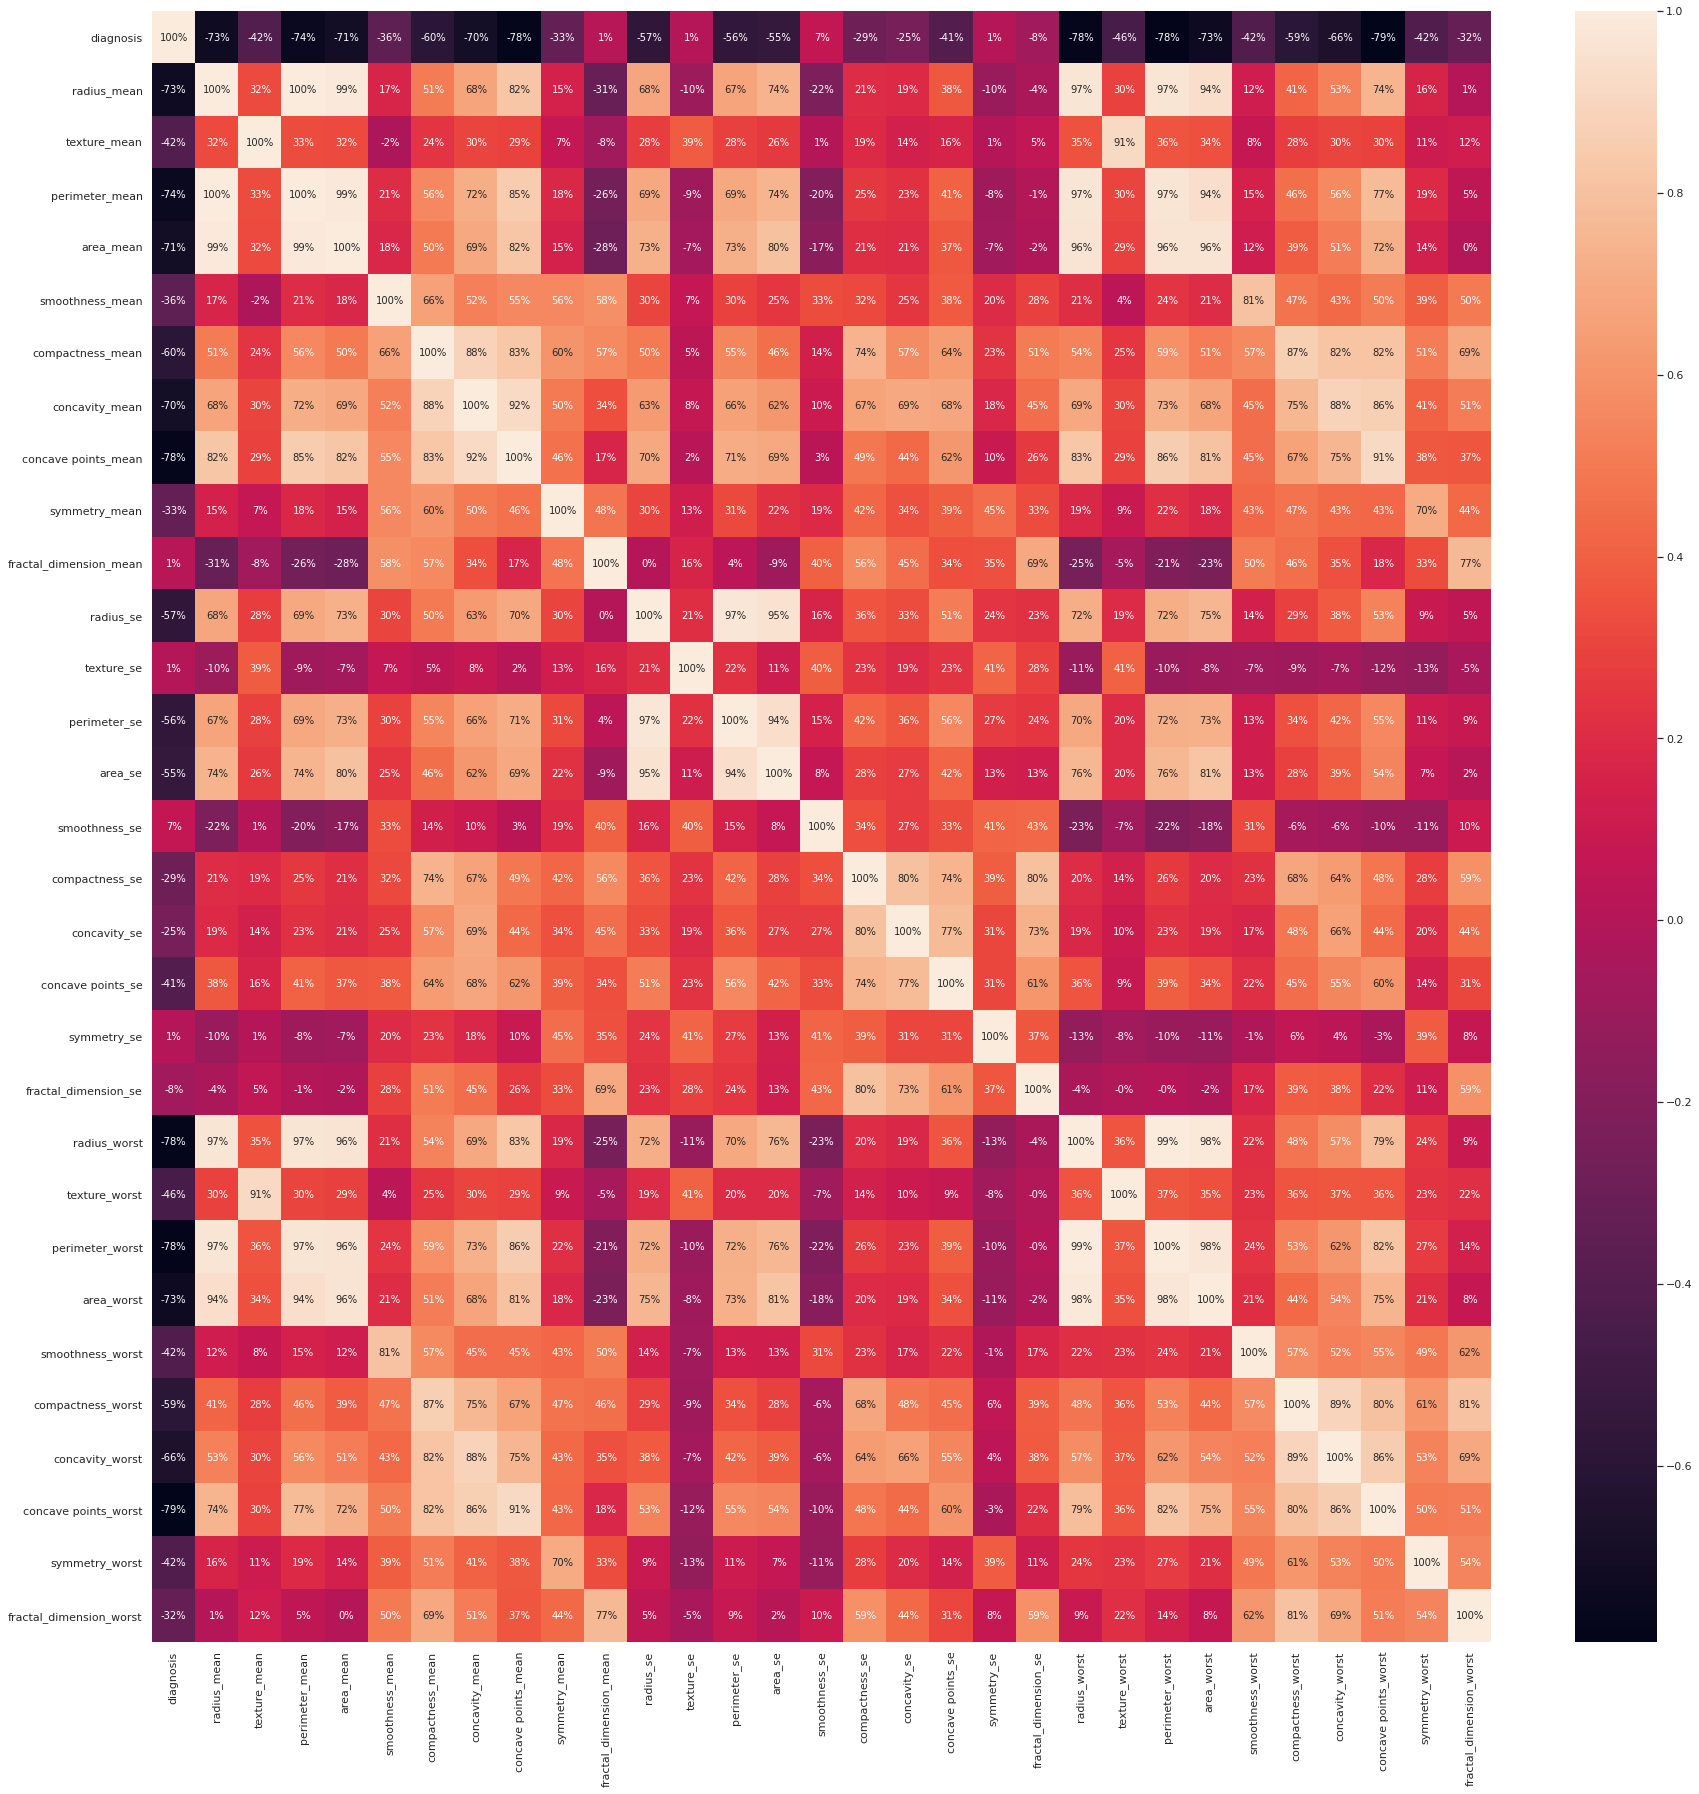

In [21]:
plt.figure(figsize=(30,30))
sns.heatmap(normalized_df.corr(), annot=True, fmt='.0%')

### Clasification Model and Evaluation

In [22]:
from pyspark.ml.linalg import Vectors
data = data.rdd.map(lambda r: [Vectors.dense(r[1:]),r[0]]).toDF(['features','label'])
data.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.52103739976882...|  0.0|
|[0.64314442873001...|  0.0|
|[0.60149556398391...|  0.0|
|[0.21009038388729...|  0.0|
|[0.62989258766174...|  0.0|
|[0.25883853435516...|  0.0|
|[0.53334277868270...|  0.0|
|[0.31847223639488...|  0.0|
|[0.28486910462379...|  0.0|
|[0.25931182503700...|  0.0|
|[0.42780065536499...|  0.0|
|[0.41644182801246...|  0.0|
|[0.57688480615615...|  0.0|
|[0.41975483298301...|  0.0|
|[0.31941875815391...|  0.0|
|[0.35775470733642...|  0.0|
|[0.36438068747520...|  0.0|
|[0.43300670385360...|  0.0|
|[0.60717493295669...|  0.0|
|[0.31042641401290...|  1.0|
+--------------------+-----+
only showing top 20 rows



#### Decision tree classifier

In [23]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(data)
# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.8, 0.2])

# Train a DecisionTree model.
dt = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dt])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "indexedLabel", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g" % (accuracy))
print("Test Error = %g" % (1.0 - accuracy))

treeModel = model.stages[2]
# summary only
print(treeModel)

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       0.0|         0.0|[0.05859244614839...|
|       0.0|         0.0|[0.07652986794710...|
|       0.0|         0.0|[0.09025507420301...|
|       0.0|         0.0|[0.09318944066762...|
|       0.0|         0.0|[0.09692840278148...|
+----------+------------+--------------------+
only showing top 5 rows

Accuracy = 0.87069
Test Error = 0.12931
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_6a4d5ee8664f) of depth 5 with 27 nodes


#### Gradient-boosted tree classifier

In [24]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(data)
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Train a GBT model.
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=10)

# Chain indexers and GBT in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, gbt])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "indexedLabel", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g" % (accuracy))
print("Test Error = %g" % (1.0 - accuracy))

gbtModel = model.stages[2]
print(gbtModel)  # summary only

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       0.0|         0.0|[0.0,0.1258031874...|
|       0.0|         0.0|[0.05750390887260...|
|       0.0|         0.0|[0.05859244614839...|
|       0.0|         0.0|[0.07652986794710...|
|       0.0|         0.0|[0.09025507420301...|
+----------+------------+--------------------+
only showing top 5 rows

Accuracy = 0.937853
Test Error = 0.0621469
GBTClassificationModel (uid=GBTClassifier_cdbcb8af991f) with 10 trees


#### Random forest classifier

In [38]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(data)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=12)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("predictedLabel", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g" % (accuracy))
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[2]
print(rfModel)  # summary only

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|           1.0|  1.0|[0.07747644931077...|
|           1.0|  1.0|[0.08258789777755...|
|           0.0|  1.0|[0.09692840278148...|
|           1.0|  1.0|[0.10374367982149...|
|           1.0|  1.0|[0.11756353825330...|
+--------------+-----+--------------------+
only showing top 5 rows

Accuracy = 0.976471
Test Error = 0.0235294
RandomForestClassificationModel (uid=RandomForestClassifier_71b7b36637d1) with 12 trees


When I review test error scores and success percentages I decide to use Random-forest classifier because its accuracy is higher than others. 

In [39]:
from sklearn.metrics import confusion_matrix

y_true = predictions.select("indexedLabel")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[102,   3],
       [  1,  64]])

In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       105
         1.0       0.96      0.98      0.97        65

    accuracy                           0.98       170
   macro avg       0.97      0.98      0.98       170
weighted avg       0.98      0.98      0.98       170



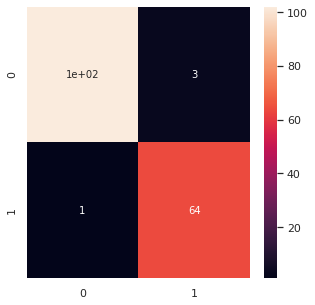

In [41]:
plt.figure(figsize=(5,5))
sns.heatmap(cnf_matrix, annot=True)

I printed the percentage of success of my model and then vizualized the confusion matrix with the help of heatmap. While the model I extracted was working with a success rate of 98 percent, it found 1 false positive value and  found 3 true negative value in 180 test data in total.